In [2]:
from llm_mri.LLM_MRI import LLM_MRI

Importing necessary packages to visualize the library's figures. 

In [3]:
import matplotlib.pyplot as plt
from datasets import load_dataset, features, ClassLabel, Dataset

Loading Emotions Dataset from Hugging Face hub

In [ ]:
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
data = load_dataset("csv", data_files=dataset_url, sep=";", 
                               names=["text", "label"], split='train[:2%]')

## Pre-processing

To evaluate the model on LLM-MRI, it is recommended to use a balanced dataset, so that different categories can be analyzed more clearly on the graph visualization.

In [5]:
emotions_df = data.to_pandas()
emotions_df.head()

text    label
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger

In [6]:
emotions_df['label'].value_counts()

label
joy         114
sadness      86
anger        46
fear         31
love         27
surprise     16
Name: count, dtype: int64

To apply our normalization, we are going to pick 8 examples total by class

In [7]:
balanced_emotions_df = emotions_df.groupby('label').apply(
    lambda group: group.head(16)
).reset_index(drop=True)


/tmp/ipykernel_11414/65254042.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_emotions_df = emotions_df.groupby('label').apply(


Having our balanced data, let's turn it into a HF Dataset to proceed with the analysis 

In [8]:
emotions = Dataset.from_pandas(balanced_emotions_df)

As the "Emotions" Dataset did not contain the "label" category, it is necessary to get the labels and turn into 'ClassLabel' type.

In [9]:
label_feature = emotions.features["label"]

class_names  = emotions.unique("label")
class_feature = features.ClassLabel(names=sorted(class_names))
emotions = emotions.map(lambda str_value: {"label": class_feature.str2int(str_value)}, input_columns="label")

emotions = emotions.cast(features.Features({
    "label": class_feature,
    "text": emotions.features["text"]}))


Casting the dataset: 100%|██████████| 96/96 [00:00<00:00, 58128.08 examples/s]


In [10]:
model_ckpt = "distilbert-base-uncased"

In [11]:
llm_mri = LLM_MRI(model=model_ckpt, device="cpu", dataset=emotions)

Map: 100%|██████████| 96/96 [00:00<00:00, 15004.22 examples/s]


## Process Areas

When the user provides a model and a corpus for activation analysis, the _process_activation_areas_ function extracts all hidden states from the model, enabling the user to visualize them as tensors. This method also reduces each hidden layers dimensionalities, building a _nxn_ representation grid.

In [12]:
llm_mri.process_activation_areas(map_dimension = 16)

Map:   0%|          | 0/96 [00:00<?, ? examples/s]

Map: 100%|██████████| 96/96 [00:03<00:00, 28.12 examples/s]


## Layer Image

The _get_layer_image_ function allows the user to visualize activations in neuron regions produced by the model's dimensionality reduction. Each cell represents a different region in a specified layer provided by the user. By passing a category as a parameter, the function enables visualization of the activations in the specified layer for the given category.

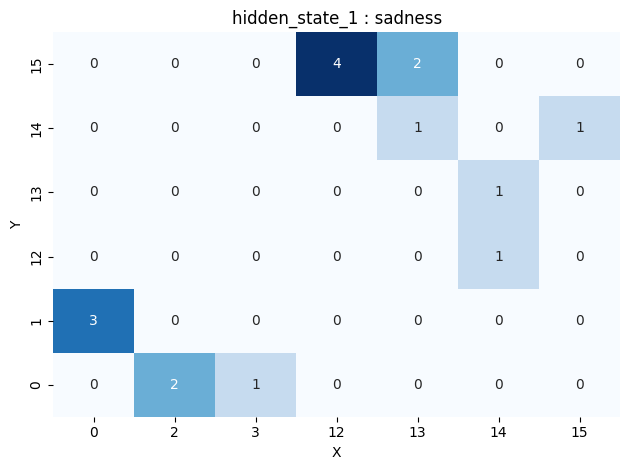

In [13]:
fig = llm_mri.get_layer_image(layer=1, category="sadness")
plt.tight_layout()
plt.show()

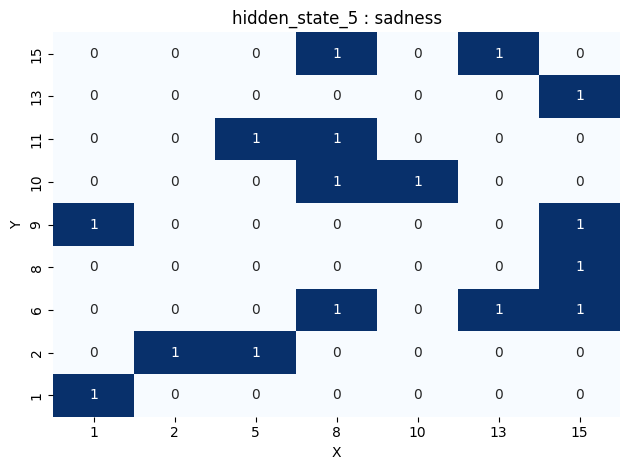

In [14]:
fig = llm_mri.get_layer_image(layer=5, category="sadness")
plt.tight_layout()
plt.show()

## Graph visualization

The _get_graph()_ function enables the user to obtain a Networkx graph representing the neuron activations in the hidden states. Each set of nodes represents activations in a specific hidden layer, while the edges between nodes indicate that documents with the specified label activated both regions.

The _get_graph_image()_ function generates an image of the graph, allowing it to be visualized by the user.


Mostrando o grafo para categorias ['sadness']
Filtered edges where the second node starts with '6':
('0_10_12', '1_12_15', {'weight': 1, 'label': 4})
('0_11_2', '1_2_0', {'weight': 1, 'label': 4})
('0_11_9', '1_13_14', {'weight': 1, 'label': 4})
('0_12_10', '1_0_1', {'weight': 1, 'label': 4})
('0_13_8', '1_13_15', {'weight': 1, 'label': 4})
('0_14_7', '1_14_13', {'weight': 1, 'label': 4})
('0_14_9', '1_15_14', {'weight': 1, 'label': 4})
('0_1_11', '1_3_0', {'weight': 1, 'label': 4})
('0_2_7', '1_14_12', {'weight': 1, 'label': 4})
tamanho ordered edges:  1
total de edges:  93
edges widths total:  93
10 firsts edges widths:  [1, 1, 1, 1, 1, 3, 1, 1, 1, 1]
FILTERED edges total:  9
-----------------------------------
total graphs filtered edges after drawing:  9
('0_10_12', '1_12_15', {'weight': 1, 'label': 4})
('0_11_2', '1_2_0', {'weight': 1, 'label': 4})
('0_11_9', '1_13_14', {'weight': 1, 'label': 4})
('0_12_10', '1_0_1', {'weight': 1, 'label': 4})
('0_13_8', '1_13_15', {'weight': 1, 

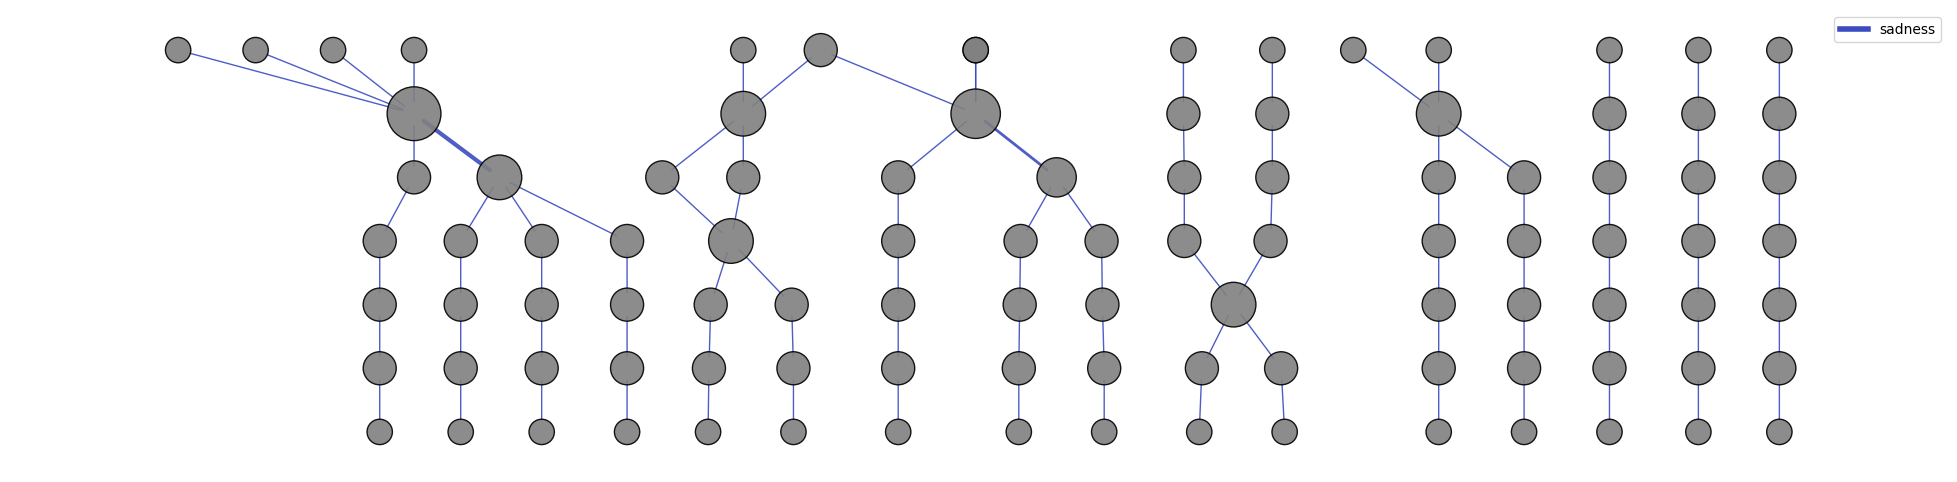

In [15]:
g = llm_mri.get_graph("sadness")

g_img = llm_mri.get_graph_image(g)
plt.box(False)
plt.show()

Here, we can see the graph visualization for the "sadness" category. Each cell represents an activation region, in the format _hiddenstate_x_y_. 

By getting the graph, it is possible to apply complex networks measurements to evaluate more densely connected nodes and regions. With that, we can evaluate the nodes with the highest centralities, identify clusters, and apply other metrics to enhance the graph's understanding.


Mostrando o grafo para categorias ['anger']
Filtered edges where the second node starts with '6':
('0_10_10', '1_3_0', {'weight': 1, 'label': 0})
('0_11_7', '1_0_1', {'weight': 1, 'label': 0})
('0_3_9', '1_13_14', {'weight': 1, 'label': 0})
('0_3_9', '1_2_0', {'weight': 1, 'label': 0})
('0_4_7', '1_12_15', {'weight': 1, 'label': 0})
('0_5_11', '1_1_0', {'weight': 1, 'label': 0})
('0_6_10', '1_14_13', {'weight': 1, 'label': 0})
('0_7_10', '1_15_13', {'weight': 1, 'label': 0})
tamanho ordered edges:  1
total de edges:  94
edges widths total:  94
10 firsts edges widths:  [1, 1, 1, 1, 2, 1, 1, 1, 1, 1]
FILTERED edges total:  8
-----------------------------------
total graphs filtered edges after drawing:  8
('0_10_10', '1_3_0', {'weight': 1, 'label': 0})
('0_11_7', '1_0_1', {'weight': 1, 'label': 0})
('0_3_9', '1_13_14', {'weight': 1, 'label': 0})
('0_3_9', '1_2_0', {'weight': 1, 'label': 0})
('0_4_7', '1_12_15', {'weight': 1, 'label': 0})
('0_5_11', '1_1_0', {'weight': 1, 'label': 0})
('

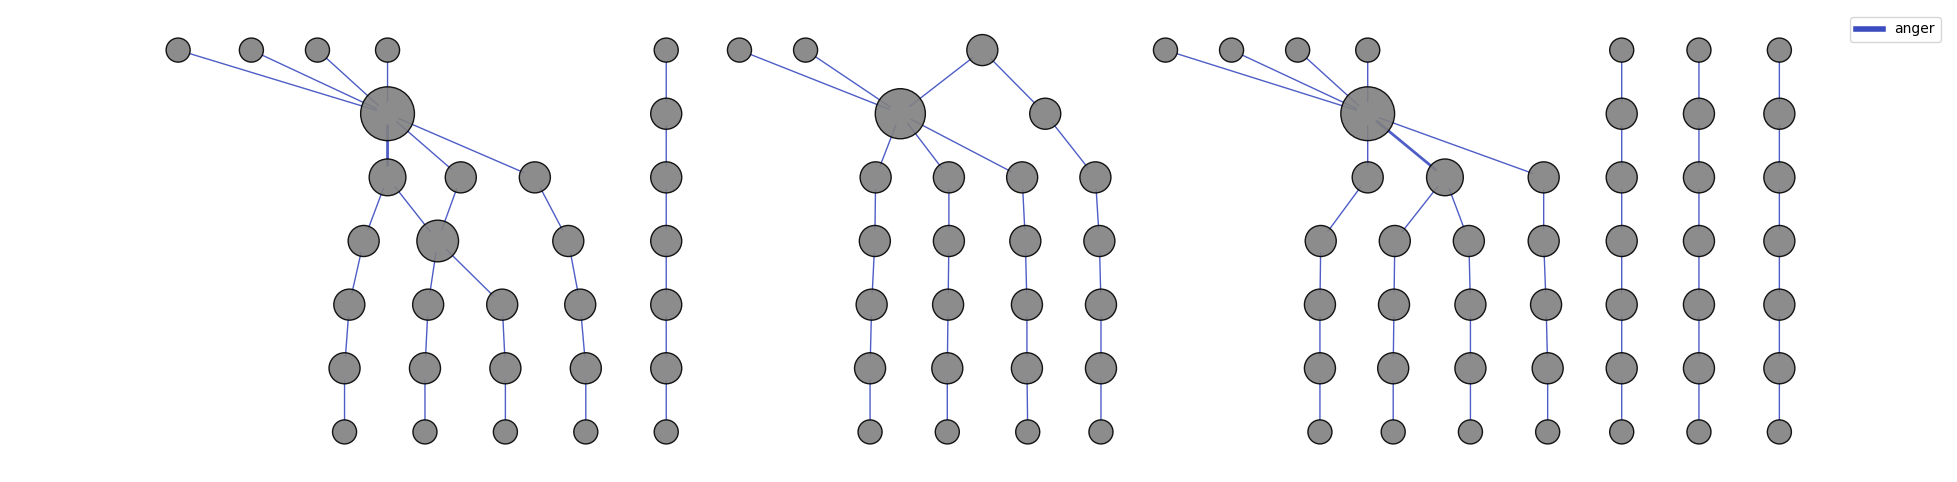

In [16]:
g = llm_mri.get_graph("anger")

g_img = llm_mri.get_graph_image(g)
plt.box(False)
plt.show()

On the image above, it is possible to visualize the graph representation for the "anger" activation regions.


Mostrando o grafo para categorias ['sadness', 'anger']
Filtered edges where the second node starts with '6':
('0_10_12', '1_12_15', {'weight': 1, 'label': 0})
('0_11_2', '1_2_0', {'weight': 1, 'label': 0})
('0_11_9', '1_13_14', {'weight': 1, 'label': 0})
('0_12_10', '1_0_1', {'weight': 1, 'label': 0})
('0_13_8', '1_13_15', {'weight': 1, 'label': 0})
('0_14_7', '1_14_13', {'weight': 1, 'label': 0})
('0_14_9', '1_15_14', {'weight': 1, 'label': 0})
('0_1_11', '1_3_0', {'weight': 1, 'label': 0})
('0_2_7', '1_14_12', {'weight': 1, 'label': 0})
('0_5_11', '1_1_0', {'weight': 1, 'label': 1})
('0_7_10', '1_15_13', {'weight': 1, 'label': 1})
tamanho ordered edges:  186
total de edges:  186
edges widths total:  186
10 firsts edges widths:  [1, 1, 1, 1, 1, 3, 1, 1, 1, 1]
FILTERED edges total:  11
-----------------------------------
total graphs filtered edges after drawing:  11
('0_10_12', '1_12_15', {'weight': 1, 'label': 0})
('0_11_2', '1_2_0', {'weight': 1, 'label': 0})
('0_11_9', '1_13_14', 

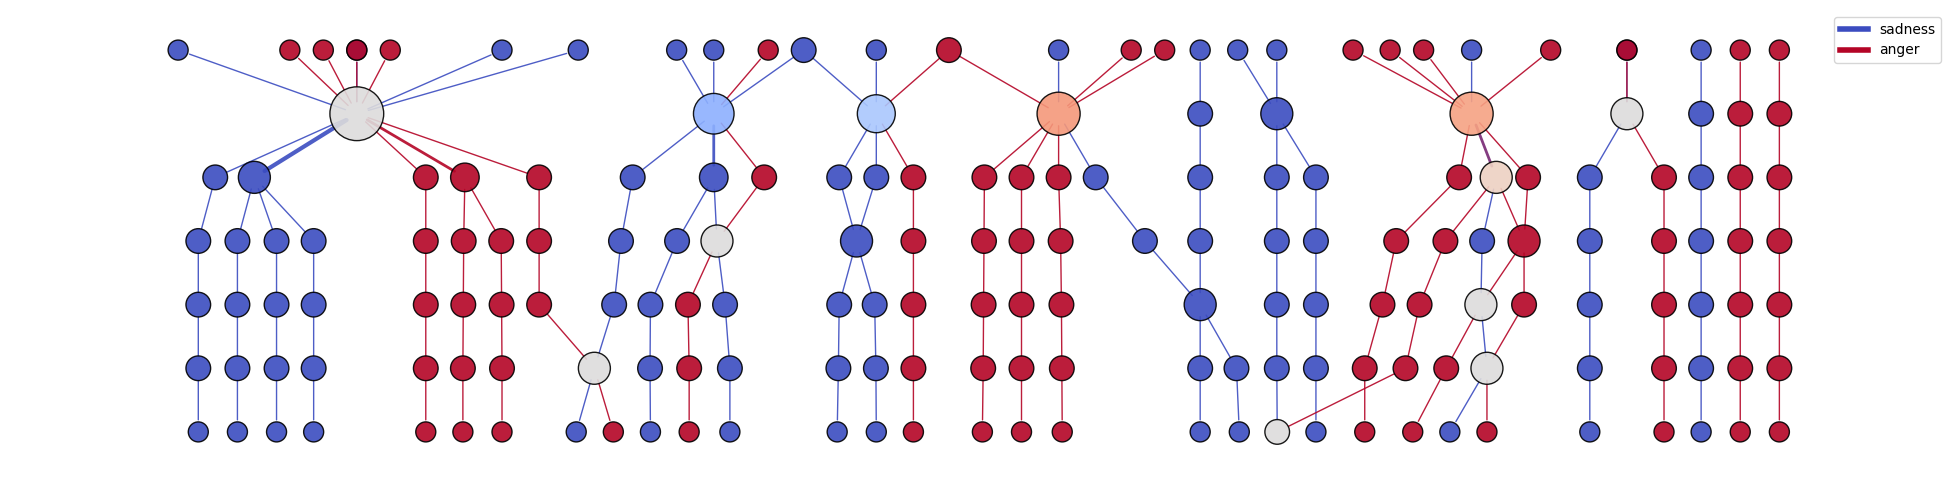

In [17]:
g_composed = llm_mri.get_composed_graph("sadness", "anger")
g_composed_img = llm_mri.get_graph_image(g_composed)

plt.box(False)
plt.show()

Through the _get_composed_graph()_ method, the user is also able to get a composed visualization of two different categories. By setting a category, each edge is colored based on the designed category, so the user is able to see which document label activated each region. On the image above, the blue color refers to the "anger" documents activations, while the green color shows "sadness" activations, and orange represent regions activated by both categories.


Mostrando o grafo para categorias ['joy']
Filtered edges where the second node starts with '6':
('0_10_4', '1_13_15', {'weight': 1, 'label': 2})
('0_11_5', '1_2_0', {'weight': 1, 'label': 2})
('0_12_6', '1_15_12', {'weight': 1, 'label': 2})
('0_2_6', '1_11_15', {'weight': 1, 'label': 2})
('0_3_5', '1_1_0', {'weight': 1, 'label': 2})
('0_4_11', '1_14_13', {'weight': 1, 'label': 2})
('0_4_12', '1_15_13', {'weight': 1, 'label': 2})
('0_5_7', '1_15_14', {'weight': 1, 'label': 2})
('0_6_12', '1_0_1', {'weight': 1, 'label': 2})
('0_7_3', '1_0_0', {'weight': 1, 'label': 2})
tamanho ordered edges:  1
total de edges:  96
edges widths total:  96
10 firsts edges widths:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
FILTERED edges total:  10
-----------------------------------
total graphs filtered edges after drawing:  10
('0_10_4', '1_13_15', {'weight': 1, 'label': 2})
('0_11_5', '1_2_0', {'weight': 1, 'label': 2})
('0_12_6', '1_15_12', {'weight': 1, 'label': 2})
('0_2_6', '1_11_15', {'weight': 1, 'label': 2

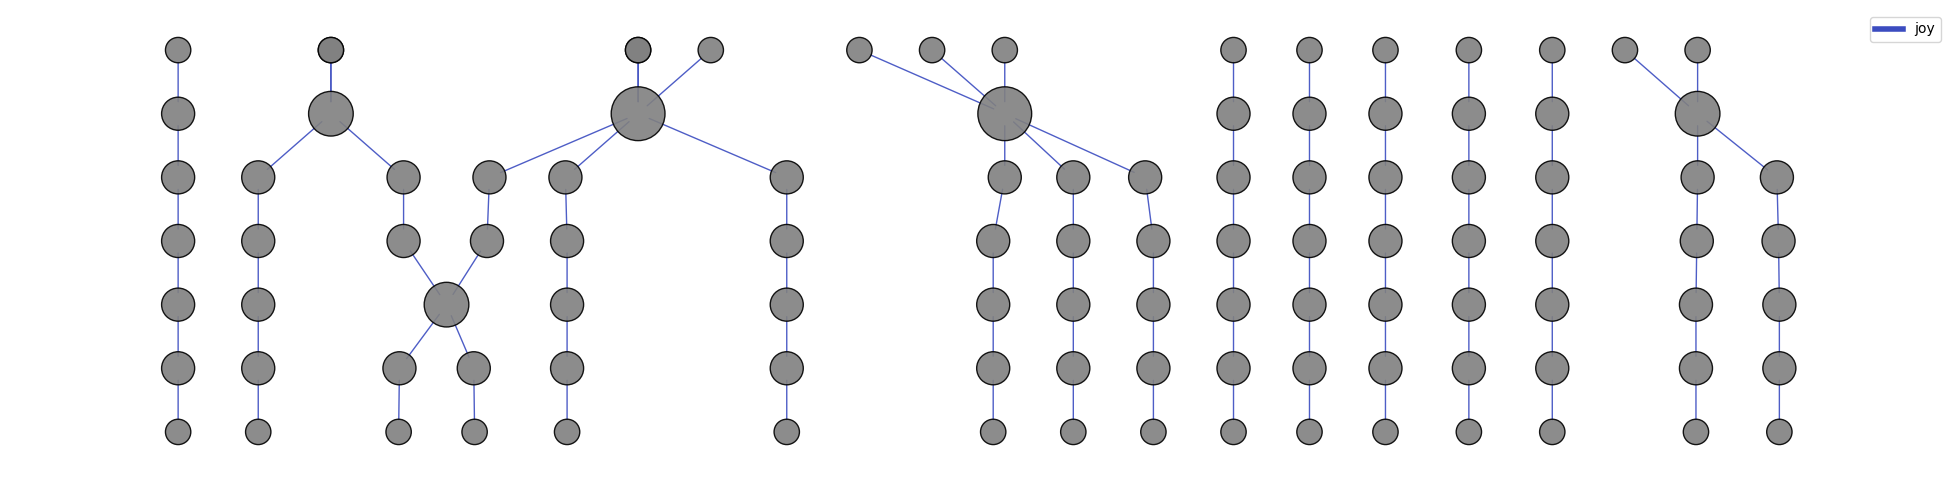

In [18]:
g = llm_mri.get_graph("joy")
img = llm_mri.get_graph_image(g)

plt.box(False)
plt.show()


Mostrando o grafo para categorias ['surprise']
Filtered edges where the second node starts with '6':
('0_0_11', '1_15_14', {'weight': 1, 'label': 5})
('0_0_9', '1_15_13', {'weight': 1, 'label': 5})
('0_10_1', '1_13_14', {'weight': 1, 'label': 5})
('0_13_12', '1_0_0', {'weight': 1, 'label': 5})
('0_13_3', '1_1_0', {'weight': 1, 'label': 5})
('0_1_4', '1_3_0', {'weight': 1, 'label': 5})
('0_3_14', '1_14_13', {'weight': 1, 'label': 5})
('0_5_14', '1_1_1', {'weight': 1, 'label': 5})
tamanho ordered edges:  1
total de edges:  95
edges widths total:  95
10 firsts edges widths:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
FILTERED edges total:  8
-----------------------------------
total graphs filtered edges after drawing:  8
('0_0_11', '1_15_14', {'weight': 1, 'label': 5})
('0_0_9', '1_15_13', {'weight': 1, 'label': 5})
('0_10_1', '1_13_14', {'weight': 1, 'label': 5})
('0_13_12', '1_0_0', {'weight': 1, 'label': 5})
('0_13_3', '1_1_0', {'weight': 1, 'label': 5})
('0_1_4', '1_3_0', {'weight': 1, 'label':

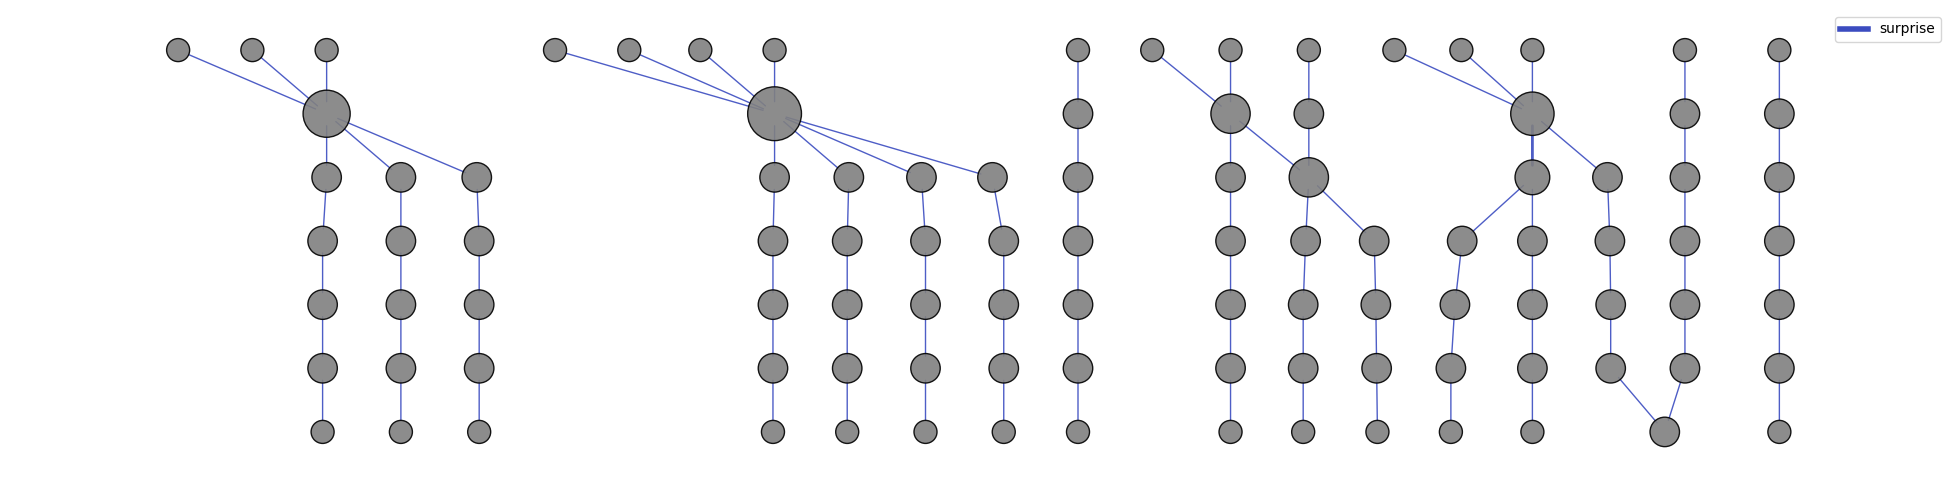

In [19]:
g = llm_mri.get_graph("surprise")
img = llm_mri.get_graph_image(g)

plt.box(False)
plt.show()

Displaying the complete graph, showing the activation regions for all different labels in one single graph.


Mostrando o grafo para categorias []
Filtered edges where the second node starts with '6':
('0_0_11', '1_15_14', {'weight': 1})
('0_0_9', '1_15_13', {'weight': 1})
('0_10_1', '1_13_14', {'weight': 1})
('0_10_10', '1_3_0', {'weight': 1})
('0_10_12', '1_12_15', {'weight': 1})
('0_10_14', '1_0_1', {'weight': 1})
('0_10_4', '1_13_15', {'weight': 1})
('0_10_5', '1_14_14', {'weight': 1})
('0_11_11', '1_1_1', {'weight': 1})
('0_11_2', '1_2_0', {'weight': 1})
('0_12_11', '1_1_0', {'weight': 1})
('0_12_6', '1_15_12', {'weight': 1})
('0_13_12', '1_0_0', {'weight': 1})
('0_14_7', '1_14_13', {'weight': 1})
('0_1_6', '1_13_13', {'weight': 1})
('0_2_6', '1_11_15', {'weight': 1})
('0_2_7', '1_14_12', {'weight': 1})
('0_5_6', '1_12_14', {'weight': 1})
tamanho ordered edges:  1
total de edges:  555
edges widths total:  555
10 firsts edges widths:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
FILTERED edges total:  18
-----------------------------------
total graphs filtered edges after drawing:  18
('0_0_11', '1_15

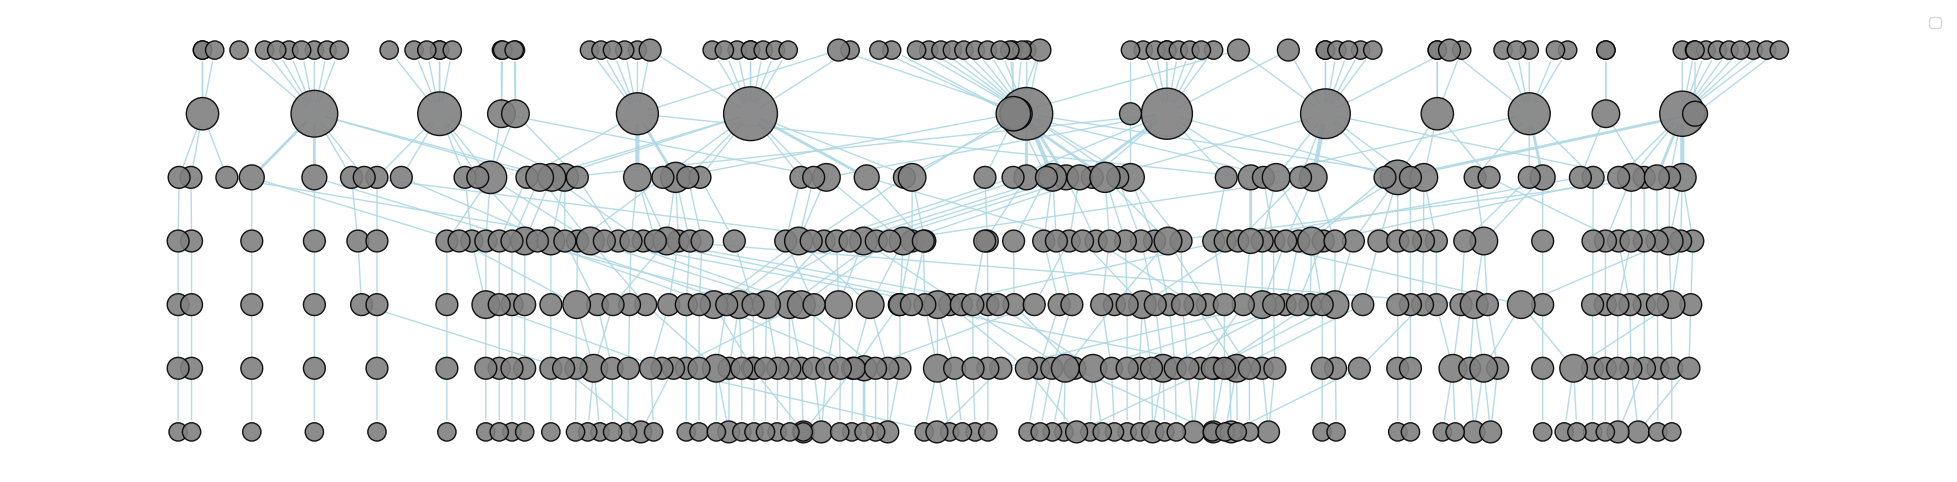

In [20]:
g = llm_mri.get_graph()
img = llm_mri.get_graph_image(g)

plt.box(False)
plt.show()

Now, we are going to evaluate the graph with


Mostrando o grafo para categorias ['joy', 'surprise']
Filtered edges where the second node starts with '6':
('0_10_4', '1_13_15', {'weight': 1, 'label': 0})
('0_11_5', '1_2_0', {'weight': 1, 'label': 0})
('0_12_6', '1_15_12', {'weight': 1, 'label': 0})
('0_2_6', '1_11_15', {'weight': 1, 'label': 0})
('0_3_5', '1_1_0', {'weight': 1, 'label': 0})
('0_4_11', '1_14_13', {'weight': 1, 'label': 0})
('0_4_12', '1_15_13', {'weight': 1, 'label': 0})
('0_5_7', '1_15_14', {'weight': 1, 'label': 0})
('0_6_12', '1_0_1', {'weight': 1, 'label': 0})
('0_7_3', '1_0_0', {'weight': 1, 'label': 0})
('0_10_1', '1_13_14', {'weight': 1, 'label': 1})
('0_1_4', '1_3_0', {'weight': 1, 'label': 1})
('0_5_14', '1_1_1', {'weight': 1, 'label': 1})
tamanho ordered edges:  189
total de edges:  189
edges widths total:  189
10 firsts edges widths:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
FILTERED edges total:  13
-----------------------------------
total graphs filtered edges after drawing:  13
('0_10_4', '1_13_15', {'weight':

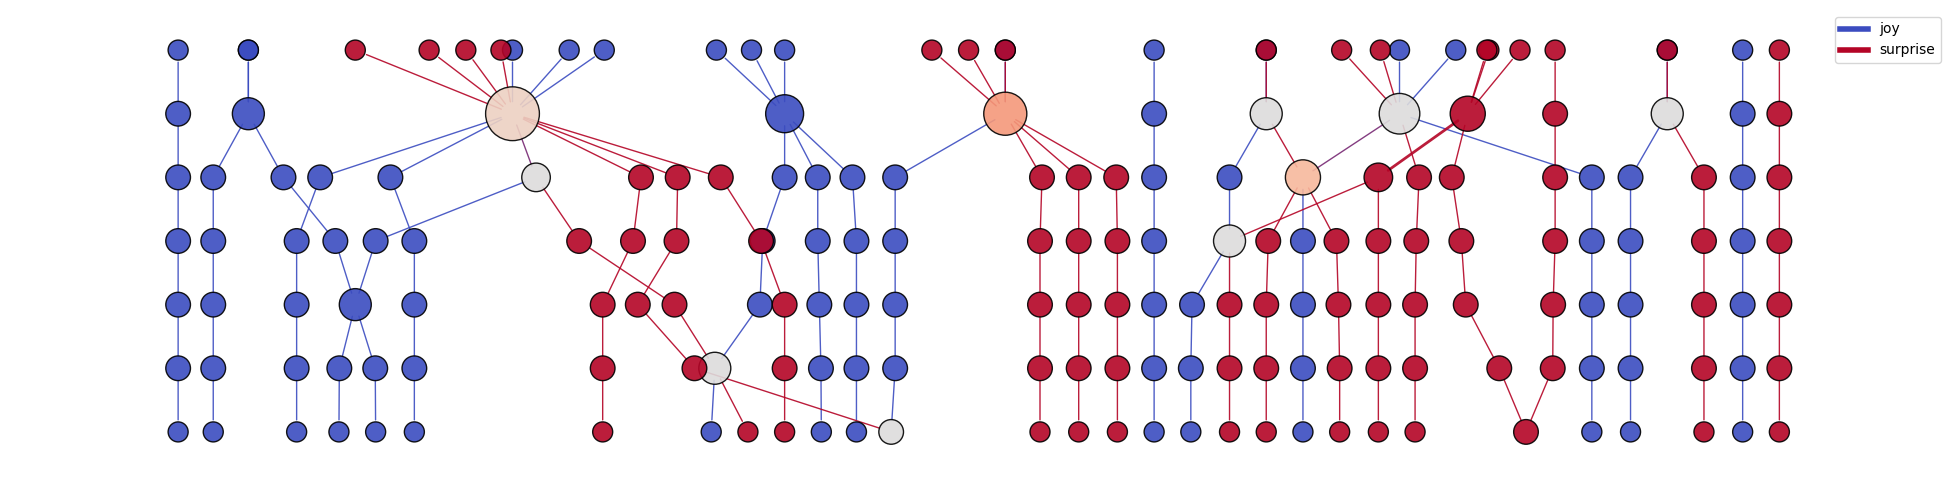

In [21]:
g_joy_surprise = llm_mri.get_composed_graph("joy", "surprise")
g_joy_surprise_img = llm_mri.get_graph_image(g_joy_surprise, fix_node_positions=True)

plt.box(False)
plt.show()


Mostrando o grafo para categorias ['joy', 'surprise']
Filtered edges where the second node starts with '6':
('0_10_4', '1_13_15', {'weight': 1, 'label': 0})
('0_11_5', '1_2_0', {'weight': 1, 'label': 0})
('0_12_6', '1_15_12', {'weight': 1, 'label': 0})
('0_2_6', '1_11_15', {'weight': 1, 'label': 0})
('0_3_5', '1_1_0', {'weight': 1, 'label': 0})
('0_4_11', '1_14_13', {'weight': 1, 'label': 0})
('0_4_12', '1_15_13', {'weight': 1, 'label': 0})
('0_5_7', '1_15_14', {'weight': 1, 'label': 0})
('0_6_12', '1_0_1', {'weight': 1, 'label': 0})
('0_7_3', '1_0_0', {'weight': 1, 'label': 0})
('0_10_1', '1_13_14', {'weight': 1, 'label': 1})
('0_1_4', '1_3_0', {'weight': 1, 'label': 1})
('0_5_14', '1_1_1', {'weight': 1, 'label': 1})
tamanho ordered edges:  189
total de edges:  189
edges widths total:  189
10 firsts edges widths:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
FILTERED edges total:  13
-----------------------------------
total graphs filtered edges after drawing:  13
('0_10_4', '1_13_15', {'weight':

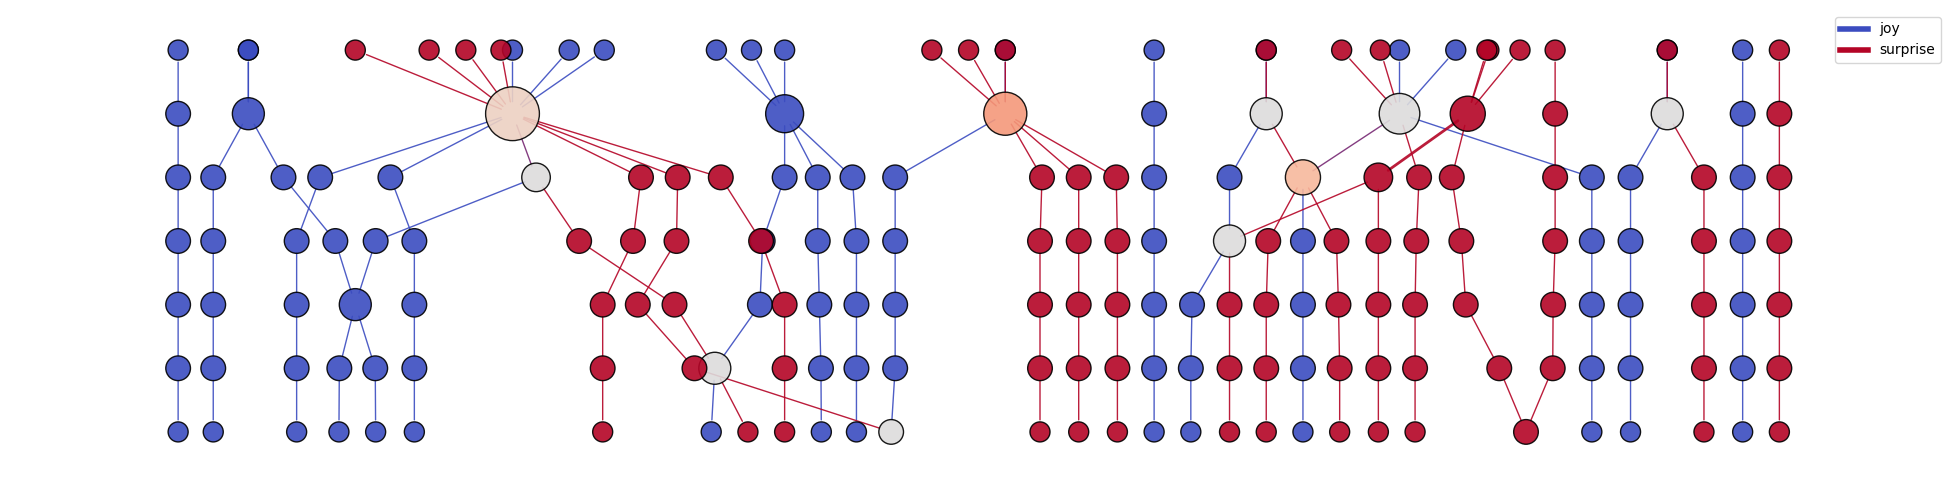

In [22]:
g_joy_anger = llm_mri.get_composed_graph("joy", "surprise")
g_joy_anger_img = llm_mri.get_graph_image(g_joy_anger, fix_node_positions=False)

plt.box(False)
plt.show()

Now, let's also visualize the activations with the fix_node_positions parameter set to False, so that the graph's display becomes more ordered:


Mostrando o grafo para categorias ['joy', 'anger']
Filtered edges where the second node starts with '6':
('0_10_4', '1_13_15', {'weight': 1, 'label': 0})
('0_11_5', '1_2_0', {'weight': 1, 'label': 0})
('0_12_6', '1_15_12', {'weight': 1, 'label': 0})
('0_2_6', '1_11_15', {'weight': 1, 'label': 0})
('0_3_5', '1_1_0', {'weight': 1, 'label': 0})
('0_4_11', '1_14_13', {'weight': 1, 'label': 0})
('0_4_12', '1_15_13', {'weight': 1, 'label': 0})
('0_5_7', '1_15_14', {'weight': 1, 'label': 0})
('0_6_12', '1_0_1', {'weight': 1, 'label': 0})
('0_7_3', '1_0_0', {'weight': 1, 'label': 0})
('2_14_9', '1_12_15', {'weight': 1, 'label': 1})
('2_15_11', '1_12_15', {'weight': 1, 'label': 1})
('0_10_10', '1_3_0', {'weight': 1, 'label': 1})
('0_3_9', '1_13_14', {'weight': 1, 'label': 1})
('0_4_7', '1_12_15', {'weight': 1, 'label': 1})
tamanho ordered edges:  189
total de edges:  189
edges widths total:  189
10 firsts edges widths:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
FILTERED edges total:  15
-----------------

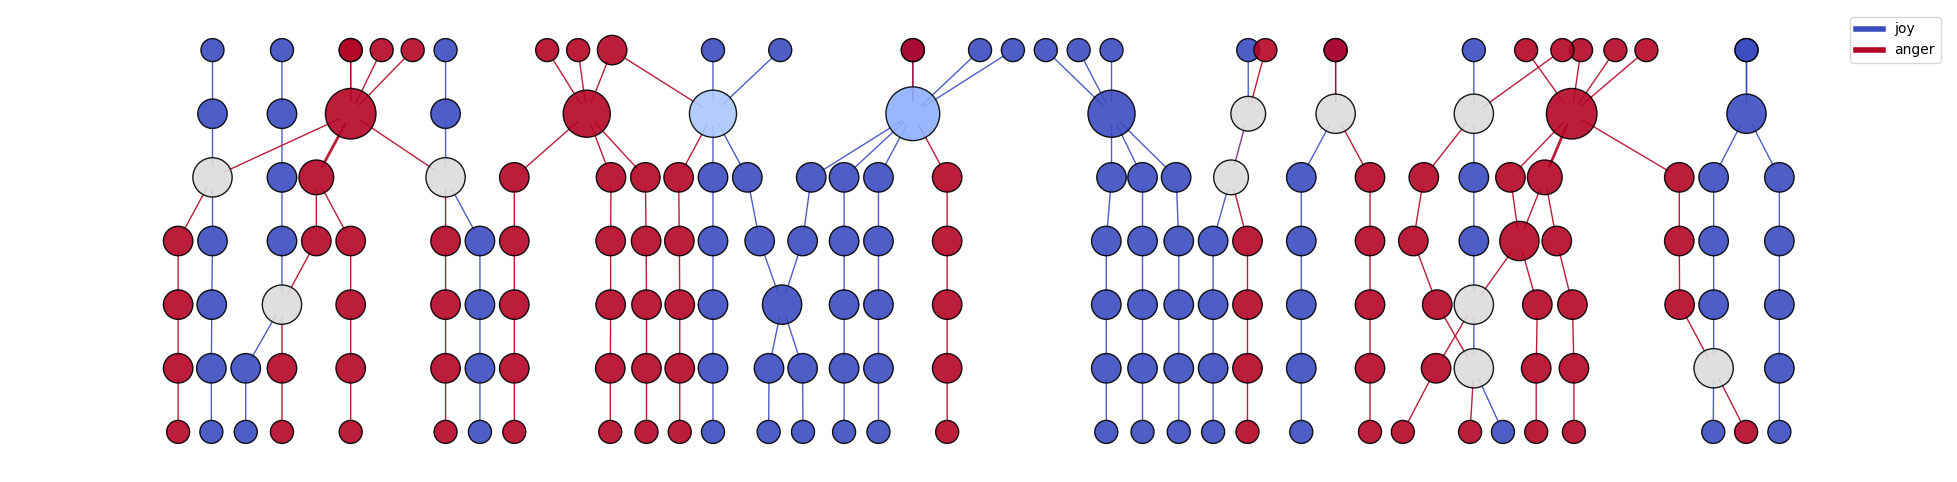

In [23]:
g_joy_anger = llm_mri.get_composed_graph("joy", "anger")
g_joy_anger_img = llm_mri.get_graph_image(g_joy_anger, fix_node_positions=False)

plt.box(False)
plt.show()

## SVD Graph Visualization Comparison

Rendering SVD-Generated graphs for comparison effect between different categories

In [24]:
g_svd_joy_surprise = llm_mri.get_composed_svd_graph("joy", "surprise", threshold=0.6)
print(g_svd_joy_surprise)
# Filter and print edges where the second node starts with '6'
filtered_edges = [
    (u, v, data) for u, v, data in g_svd_joy_surprise.edges(data=True) if v.startswith('6')
]

print("Filtered edges where the second node starts with '6':")
for i, edge in enumerate(filtered_edges):
    print(i, ")", edge)

/home/lipecorradini/desktop/unicamp/ic/LLM-MRI/llm_mri/Treatment.py:138: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = stats.spearmanr(first_layer_np[:, i], second_layer_np[:, j])


      0_0  0_1  0_2  0_3  0_4  0_5  0_6  0_7  0_8  0_9  0_10  0_11  0_12  \
1_0   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_1   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_2   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_3   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_4   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_5   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_6   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_7   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_8   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_9   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_10  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_11  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_12  NaN  N

/home/lipecorradini/desktop/unicamp/ic/LLM-MRI/llm_mri/Treatment.py:138: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = stats.spearmanr(first_layer_np[:, i], second_layer_np[:, j])


      0_0  0_1  0_2  0_3  0_4  0_5  0_6  0_7  0_8  0_9  0_10  0_11  0_12  \
1_0   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_1   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_2   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_3   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_4   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_5   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_6   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_7   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_8   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_9   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_10  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_11  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_12  NaN  N

/home/lipecorradini/desktop/unicamp/ic/LLM-MRI/llm_mri/Treatment.py:138: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = stats.spearmanr(first_layer_np[:, i], second_layer_np[:, j])


      0_0  0_1  0_2  0_3  0_4  0_5  0_6  0_7  0_8  0_9  0_10  0_11  0_12  \
1_0   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_1   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_2   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_3   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_4   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_5   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_6   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_7   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_8   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_9   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_10  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_11  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_12  NaN  N

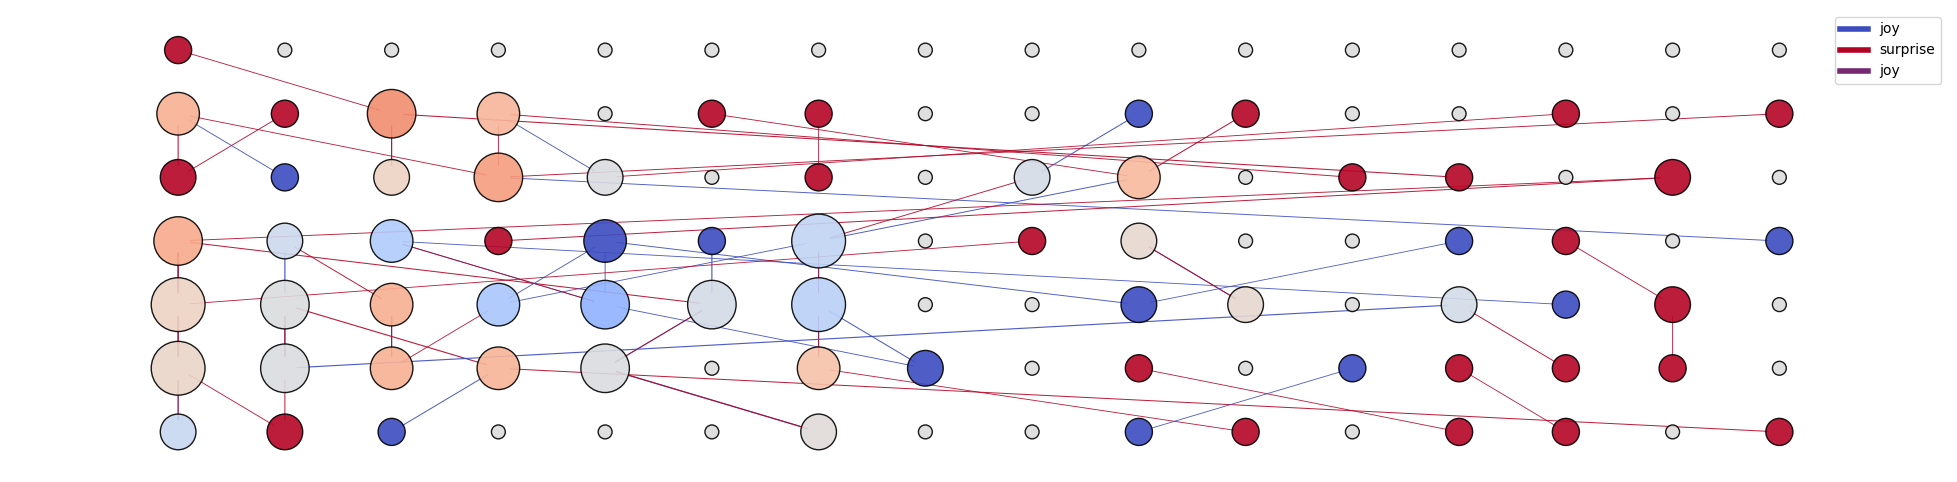

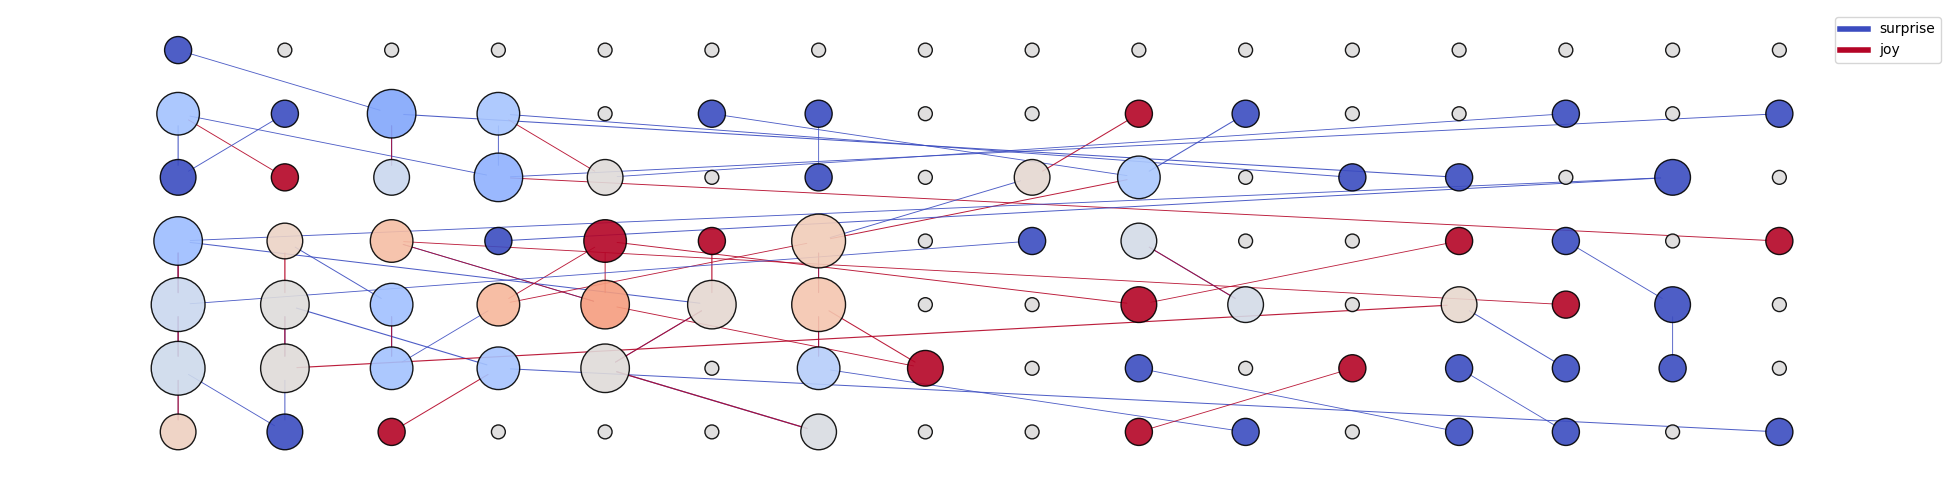

In [25]:
g_svd_joy_surprise = llm_mri.get_composed_svd_graph("joy", "surprise", threshold=0.6)

g_svd_joy_surprise_img = llm_mri.get_graph_image(g_svd_joy_surprise)

g_svd_surprise_joy = llm_mri.get_composed_svd_graph("surprise", "joy", threshold=0.6)

g_svd_surprise_joy_img = llm_mri.get_graph_image(g_svd_surprise_joy)

plt.show()

Side-to-side UMAP graphs and PCA graphs:

           0_0       0_1       0_2       0_3       0_4       0_5       0_6  \
1_0  -0.153393 -0.038348 -0.115045  0.306786  0.306786 -0.076696  0.306786   
1_1  -0.238235  0.167647 -0.123529 -0.223529  0.020588  0.141176 -0.141176   
1_2  -0.032353  0.179412  0.238235  0.138235 -0.002941  0.235294  0.420588   
1_3   0.076471 -0.214706 -0.317647  0.017647  0.067647 -0.114706  0.235294   
1_4  -0.311765  0.091176 -0.126471  0.185294 -0.164706 -0.617647 -0.105882   
1_5  -0.077278  0.345820 -0.171944 -0.581519 -0.523560  0.090802  0.048299   
1_6   0.241176  0.344118  0.308824  0.270588  0.217647 -0.270588 -0.564706   
1_7  -0.132353 -0.161765  0.002941 -0.126471 -0.217647 -0.347059 -0.058824   
1_8  -0.126471  0.179412 -0.020588 -0.088235 -0.188235 -0.147059  0.035294   
1_9  -0.220588 -0.064706 -0.429412 -0.061765 -0.038235 -0.117647  0.105882   
1_10  0.647059 -0.029412  0.517647  0.191176 -0.005882  0.244118 -0.102941   
1_11 -0.128736  0.464879 -0.121584  0.125160  0.225288 -0.125160

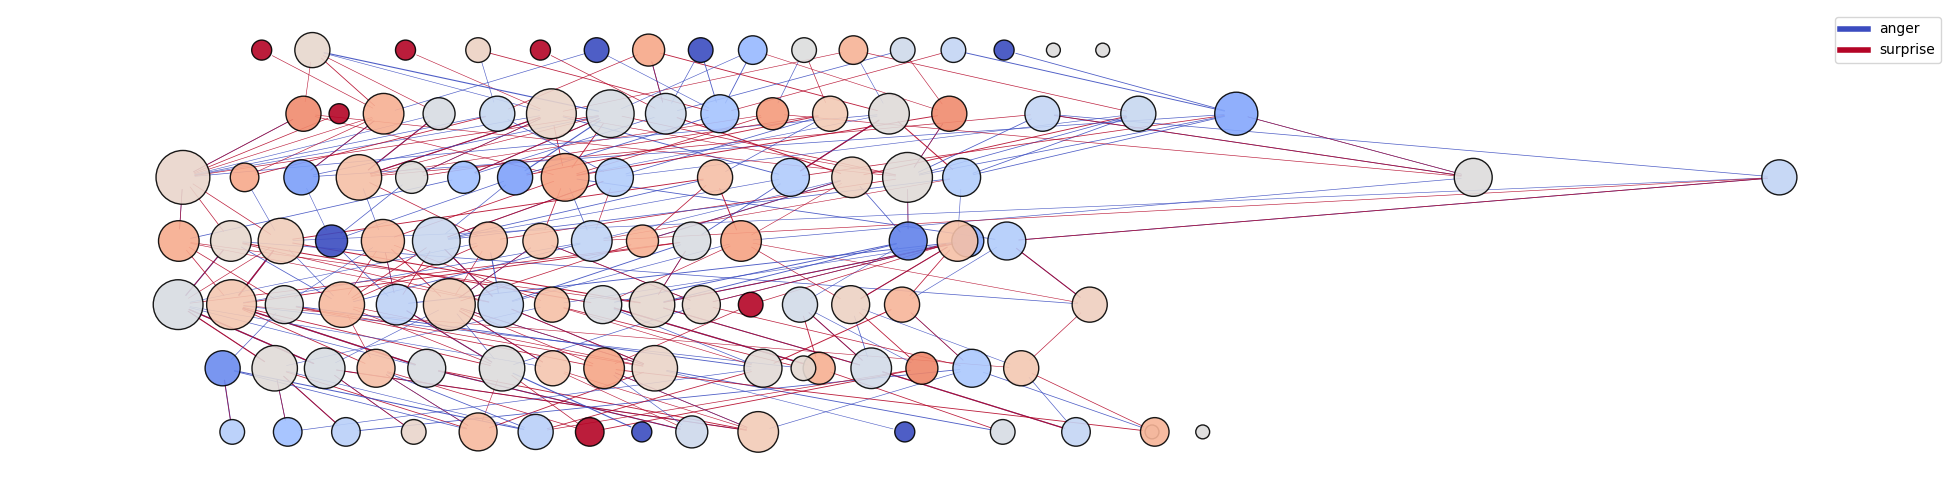

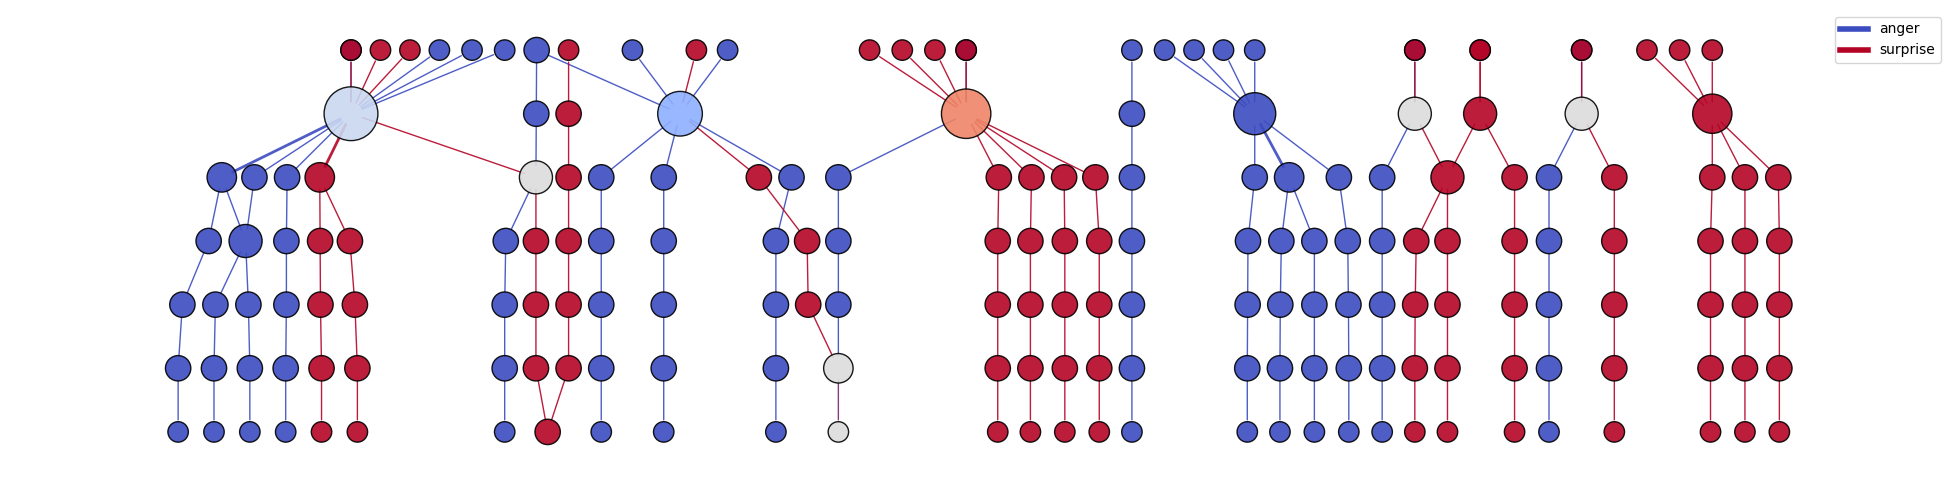

In [26]:
# PCA Graph
g_svd_anger_surprise_pca = llm_mri.get_composed_svd_graph("anger", "surprise", threshold=0.4)

g_svd_anger_surprise_img_pca = llm_mri.get_graph_image(g_svd_anger_surprise_pca, fix_node_dimensions=False)

# UMAP Graph
g_svd_anger_surprise = llm_mri.get_composed_graph("anger", "surprise")

g_svd_anger_surprise_img = llm_mri.get_graph_image(g_svd_anger_surprise)

plt.show()

### Two distinct PCA Graphs comparison:

           0_0       0_1       0_2       0_3       0_4       0_5       0_6  \
1_0  -0.153393 -0.038348 -0.115045  0.306786  0.306786 -0.076696  0.306786   
1_1  -0.238235  0.167647 -0.123529 -0.223529  0.020588  0.141176 -0.141176   
1_2  -0.032353  0.179412  0.238235  0.138235 -0.002941  0.235294  0.420588   
1_3   0.076471 -0.214706 -0.317647  0.017647  0.067647 -0.114706  0.235294   
1_4  -0.311765  0.091176 -0.126471  0.185294 -0.164706 -0.617647 -0.105882   
1_5  -0.077278  0.345820 -0.171944 -0.581519 -0.523560  0.090802  0.048299   
1_6   0.241176  0.344118  0.308824  0.270588  0.217647 -0.270588 -0.564706   
1_7  -0.132353 -0.161765  0.002941 -0.126471 -0.217647 -0.347059 -0.058824   
1_8  -0.126471  0.179412 -0.020588 -0.088235 -0.188235 -0.147059  0.035294   
1_9  -0.220588 -0.064706 -0.429412 -0.061765 -0.038235 -0.117647  0.105882   
1_10  0.647059 -0.029412  0.517647  0.191176 -0.005882  0.244118 -0.102941   
1_11 -0.128736  0.464879 -0.121584  0.125160  0.225288 -0.125160

/home/lipecorradini/desktop/unicamp/ic/LLM-MRI/llm_mri/Treatment.py:138: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = stats.spearmanr(first_layer_np[:, i], second_layer_np[:, j])


      0_0  0_1  0_2  0_3  0_4  0_5  0_6  0_7  0_8  0_9  0_10  0_11  0_12  \
1_0   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_1   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_2   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_3   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_4   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_5   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_6   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_7   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_8   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_9   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_10  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_11  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_12  NaN  N

/home/lipecorradini/desktop/unicamp/ic/LLM-MRI/llm_mri/Treatment.py:138: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = stats.spearmanr(first_layer_np[:, i], second_layer_np[:, j])


      0_0  0_1  0_2  0_3  0_4  0_5  0_6  0_7  0_8  0_9  0_10  0_11  0_12  \
1_0   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_1   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_2   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_3   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_4   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_5   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_6   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_7   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_8   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_9   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_10  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_11  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_12  NaN  N

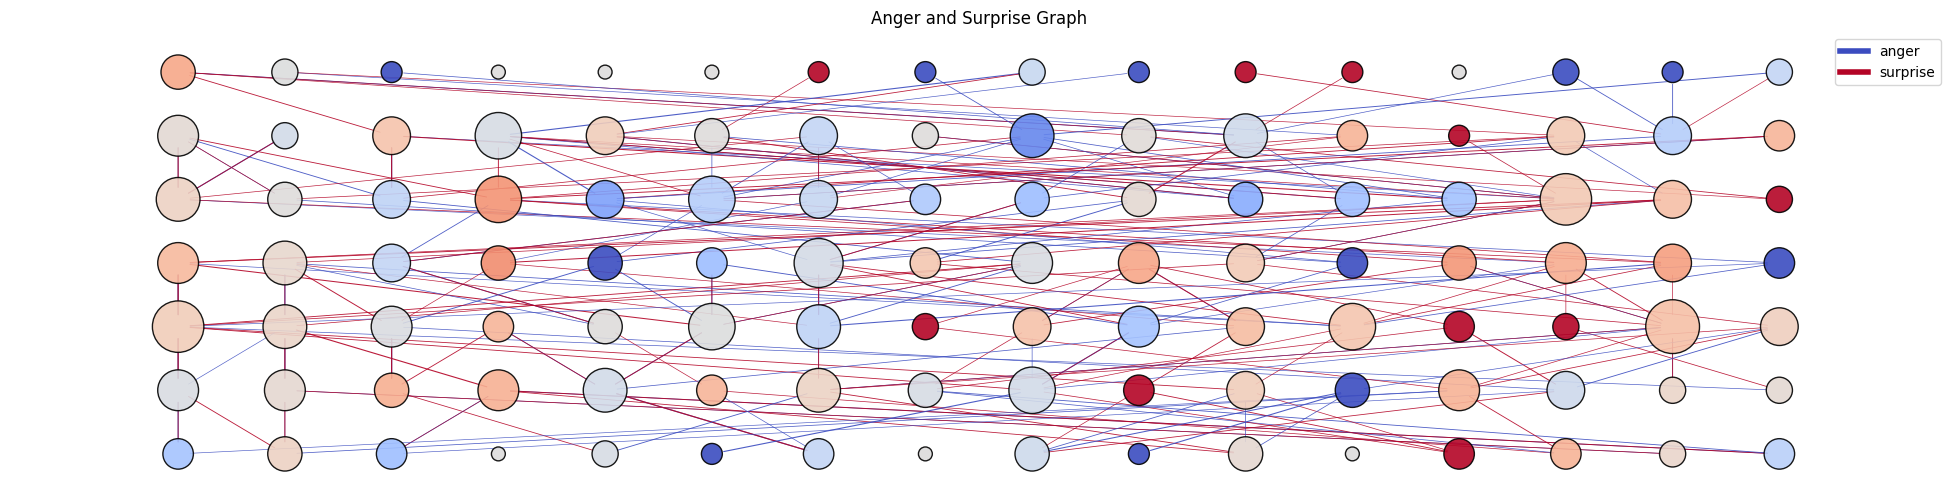

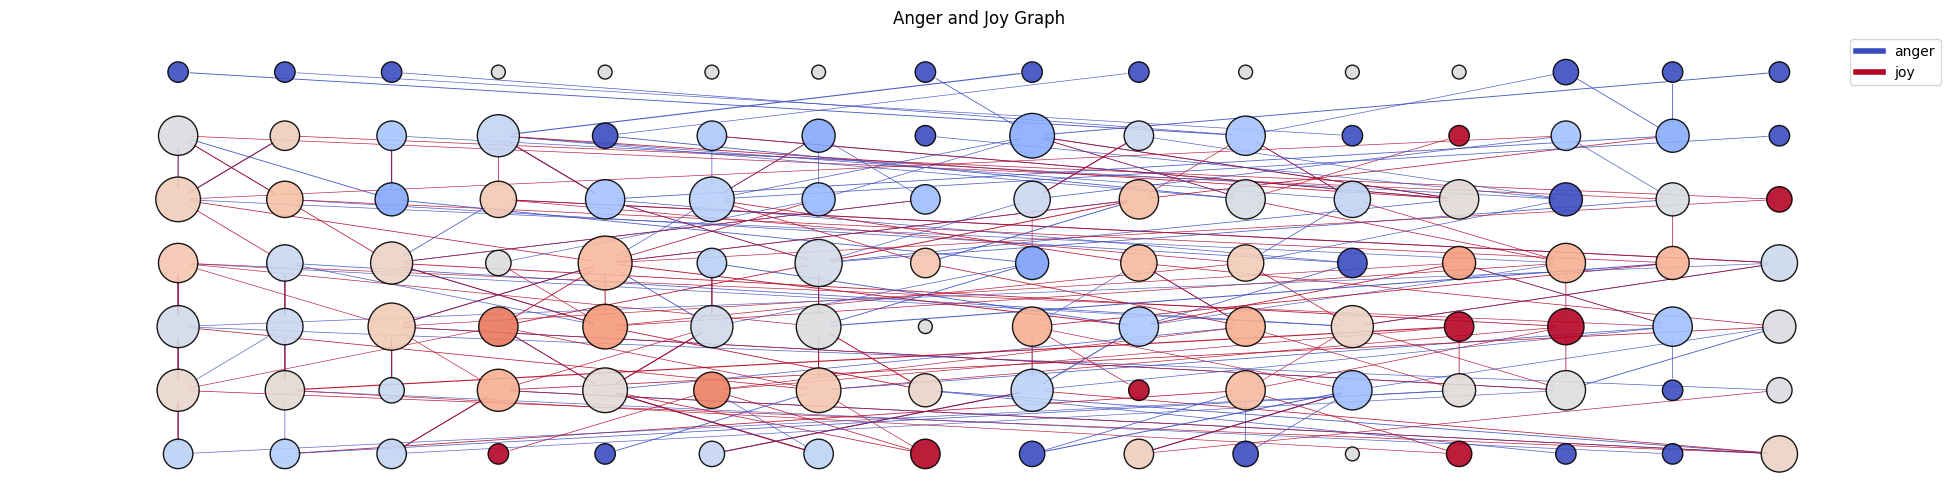

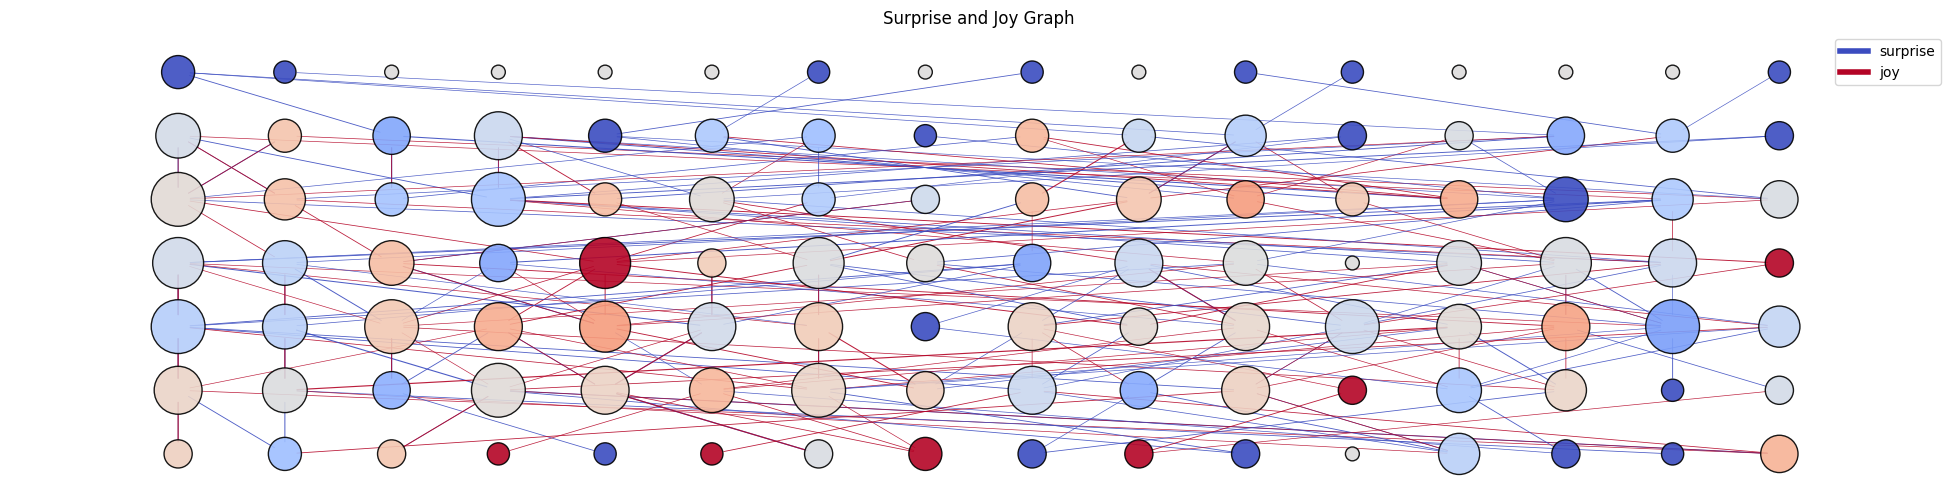

In [27]:
# Anger and Surprise Graph
g_svd_anger_surprise_pca = llm_mri.get_composed_svd_graph("anger", "surprise", threshold=0.45)
g_svd_anger_surprise_img_pca = llm_mri.get_graph_image(g_svd_anger_surprise_pca, fix_node_dimensions=True)
plt.title("Anger and Surprise Graph")


# Anger and joy Graph
g_svd_anger_joy_pca = llm_mri.get_composed_svd_graph("anger", "joy", threshold=0.45)
g_svd_anger_joy_img_pca = llm_mri.get_graph_image(g_svd_anger_joy_pca, fix_node_dimensions=True)
plt.title("Anger and Joy Graph")

# Surprise and Joy Graph
g_svd_surprise_joy_pca = llm_mri.get_composed_svd_graph("surprise", "joy", threshold=0.45)
g_svd_surprise_joy_img_pca = llm_mri.get_graph_image(g_svd_surprise_joy_pca, fix_node_dimensions=True)
plt.title("Surprise and Joy Graph")



plt.show()

/home/lipecorradini/desktop/unicamp/ic/LLM-MRI/llm_mri/Treatment.py:138: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = stats.spearmanr(first_layer_np[:, i], second_layer_np[:, j])


           0_0       0_1       0_2       0_3       0_4       0_5       0_6  \
1_0        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1_1  -0.115045  0.153393 -0.115045 -0.153393  0.038348  0.268438  0.076696   
1_2  -0.115045  0.153393 -0.115045 -0.153393  0.038348  0.268438  0.076696   
1_3   0.115045 -0.153393  0.115045  0.153393 -0.038348 -0.268438 -0.076696   
1_4  -0.084017 -0.196039 -0.196039 -0.196039  0.028006 -0.364073  0.196039   
1_5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1_6  -0.084017 -0.196039 -0.196039 -0.196039  0.028006 -0.364073  0.196039   
1_7  -0.115045  0.153393 -0.115045 -0.153393  0.038348  0.268438  0.076696   
1_8   0.084017  0.196039  0.196039  0.196039 -0.028006  0.364073 -0.196039   
1_9  -0.084017 -0.196039 -0.196039 -0.196039  0.028006 -0.364073  0.196039   
1_10  0.115045 -0.153393  0.115045  0.153393 -0.038348 -0.268438 -0.076696   
1_11       NaN       NaN       NaN       NaN       NaN       NaN

/home/lipecorradini/desktop/unicamp/ic/LLM-MRI/llm_mri/Treatment.py:138: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = stats.spearmanr(first_layer_np[:, i], second_layer_np[:, j])


      0_0  0_1  0_2  0_3  0_4  0_5  0_6  0_7  0_8  0_9  0_10  0_11  0_12  \
1_0   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_1   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_2   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_3   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_4   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_5   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_6   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_7   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_8   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_9   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_10  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_11  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_12  NaN  N

/home/lipecorradini/desktop/unicamp/ic/LLM-MRI/llm_mri/Treatment.py:138: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = stats.spearmanr(first_layer_np[:, i], second_layer_np[:, j])


           0_0       0_1       0_2       0_3       0_4       0_5       0_6  \
1_0        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1_1  -0.115045  0.153393 -0.115045 -0.153393  0.038348  0.268438  0.076696   
1_2  -0.115045  0.153393 -0.115045 -0.153393  0.038348  0.268438  0.076696   
1_3   0.115045 -0.153393  0.115045  0.153393 -0.038348 -0.268438 -0.076696   
1_4  -0.084017 -0.196039 -0.196039 -0.196039  0.028006 -0.364073  0.196039   
1_5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1_6  -0.084017 -0.196039 -0.196039 -0.196039  0.028006 -0.364073  0.196039   
1_7  -0.115045  0.153393 -0.115045 -0.153393  0.038348  0.268438  0.076696   
1_8   0.084017  0.196039  0.196039  0.196039 -0.028006  0.364073 -0.196039   
1_9  -0.084017 -0.196039 -0.196039 -0.196039  0.028006 -0.364073  0.196039   
1_10  0.115045 -0.153393  0.115045  0.153393 -0.038348 -0.268438 -0.076696   
1_11       NaN       NaN       NaN       NaN       NaN       NaN

/home/lipecorradini/desktop/unicamp/ic/LLM-MRI/llm_mri/Treatment.py:138: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = stats.spearmanr(first_layer_np[:, i], second_layer_np[:, j])


      0_0  0_1  0_2  0_3  0_4  0_5  0_6  0_7  0_8  0_9  0_10  0_11  0_12  \
1_0   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_1   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_2   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_3   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_4   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_5   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_6   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_7   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_8   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_9   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_10  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_11  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_12  NaN  N

/home/lipecorradini/desktop/unicamp/ic/LLM-MRI/llm_mri/Treatment.py:138: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = stats.spearmanr(first_layer_np[:, i], second_layer_np[:, j])


      0_0  0_1  0_2  0_3  0_4  0_5  0_6  0_7  0_8  0_9  0_10  0_11  0_12  \
1_0   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_1   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_2   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_3   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_4   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_5   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_6   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_7   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_8   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_9   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_10  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_11  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_12  NaN  N

/home/lipecorradini/desktop/unicamp/ic/LLM-MRI/llm_mri/Treatment.py:138: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = stats.spearmanr(first_layer_np[:, i], second_layer_np[:, j])


      0_0  0_1  0_2  0_3  0_4  0_5  0_6  0_7  0_8  0_9  0_10  0_11  0_12  \
1_0   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_1   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_2   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_3   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_4   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_5   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_6   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_7   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_8   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_9   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_10  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_11  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   
1_12  NaN  N

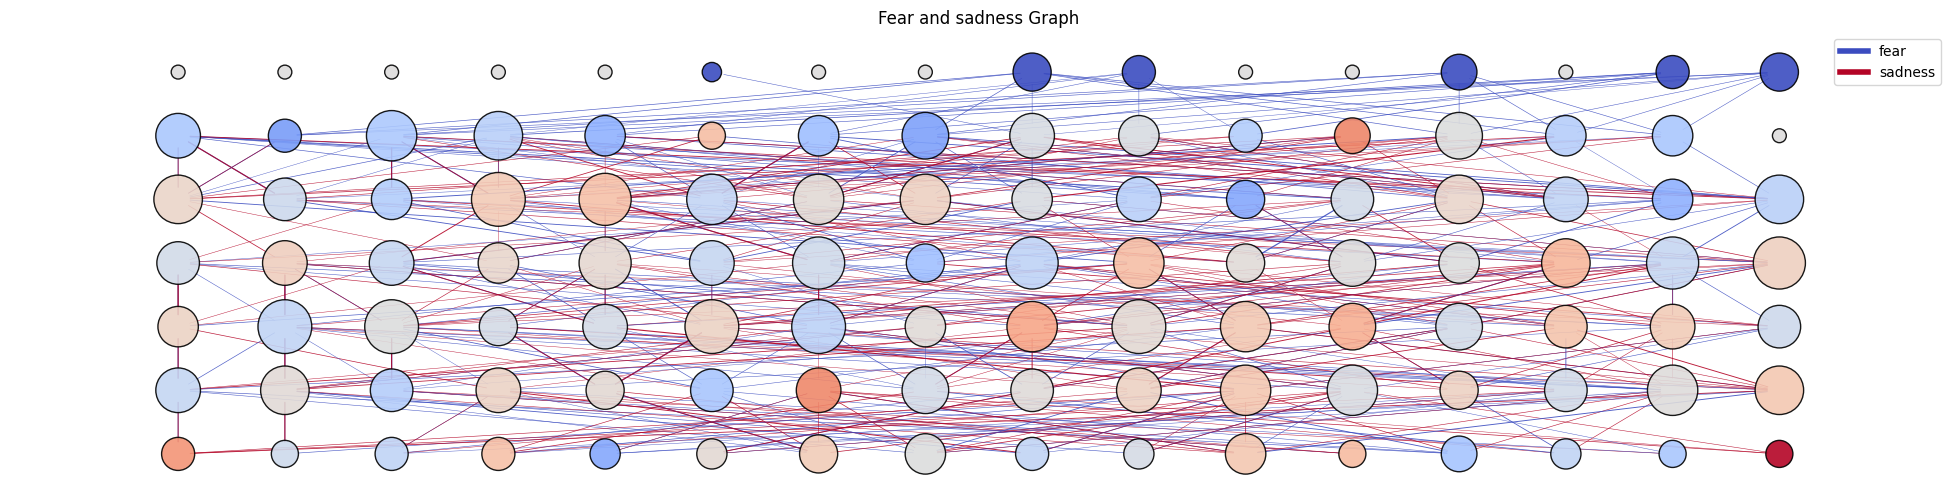

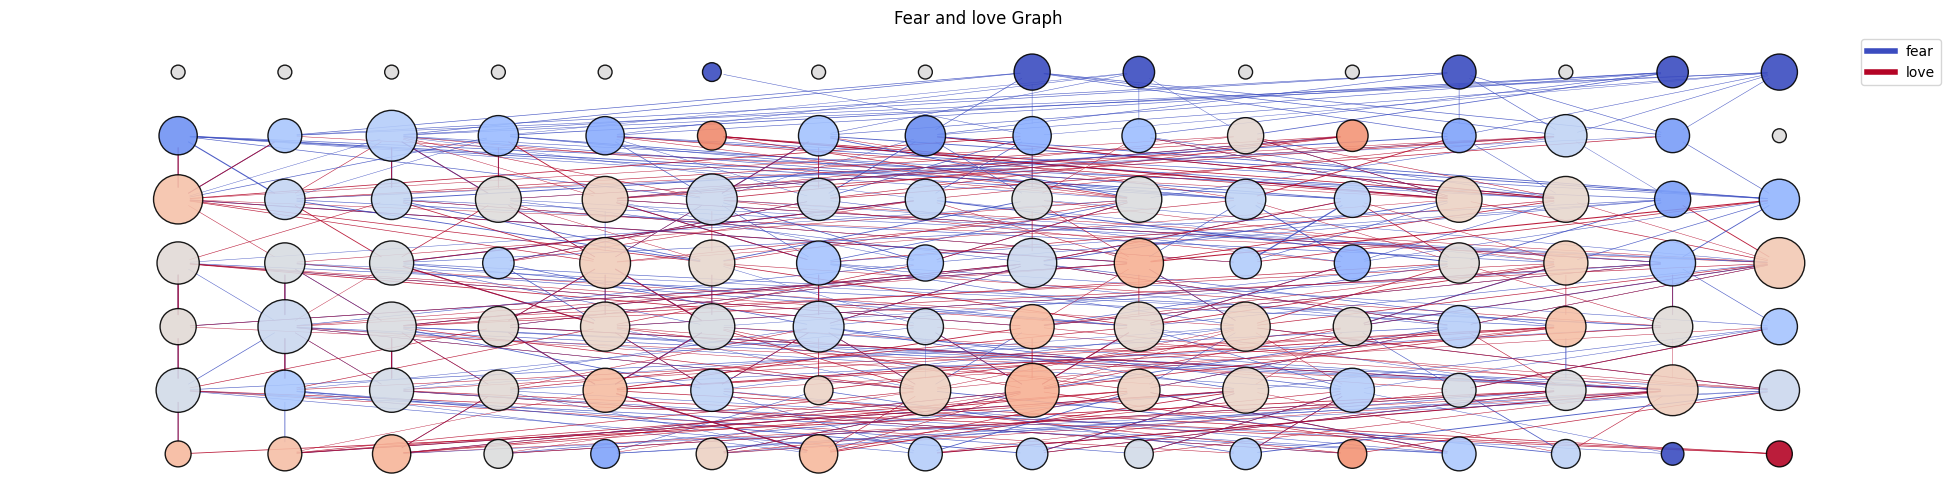

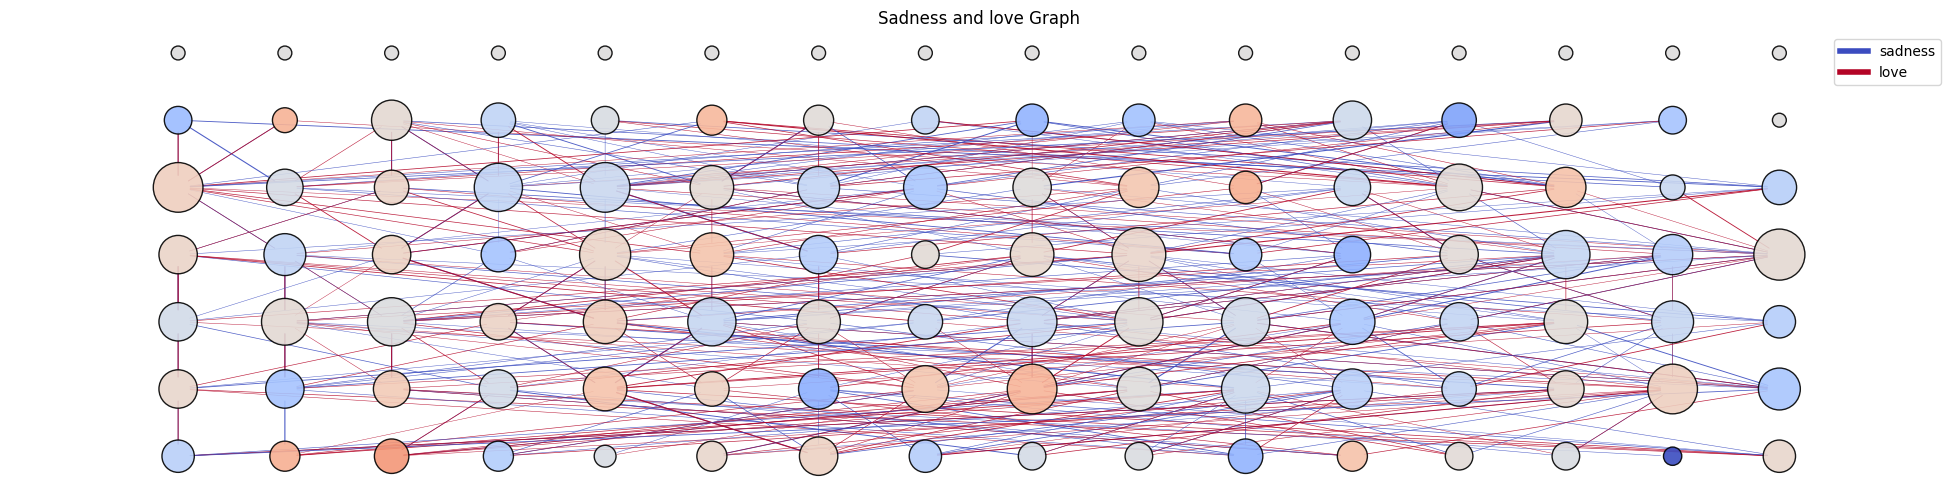

In [28]:
# fear and Surprise Graph
g_svd_fear_sadness_pca = llm_mri.get_composed_svd_graph("fear", "sadness", threshold=0.3)
g_svd_fear_sadness_img_pca = llm_mri.get_graph_image(g_svd_fear_sadness_pca, fix_node_dimensions=True)
plt.title("Fear and sadness Graph")

# fear and love Graph
g_svd_fear_love_pca = llm_mri.get_composed_svd_graph("fear", "love", threshold=0.3)
g_svd_fear_love_img_pca = llm_mri.get_graph_image(g_svd_fear_love_pca, fix_node_dimensions=True)
plt.title("Fear and love Graph")

# sadness and love Graph
g_svd_sadness_love_pca = llm_mri.get_composed_svd_graph("sadness", "love", threshold=0.3)
g_svd_surprise_love_img_pca = llm_mri.get_graph_image(g_svd_sadness_love_pca, fix_node_dimensions=True)
plt.title("Sadness and love Graph")



plt.show()

In [29]:
reduced_hds = llm_mri.get_svd_reduction()
reduced_spearman = llm_mri.get_spearman_graph(reduced_hds)
print(reduced_spearman)

           0_0       0_1       0_2       0_3       0_4       0_5       0_6  \
1_0   0.111972 -0.090802  0.064227  0.257113 -0.056385  0.193254  0.269745   
1_1  -0.127416  0.065270  0.009361  0.030661  0.025144  0.095698  0.000176   
1_2   0.004500  0.136585 -0.005021 -0.051337  0.011115  0.051753  0.079435   
1_3   0.167647 -0.157565 -0.042288  0.136153 -0.024423  0.146290  0.182412   
1_4  -0.145433  0.003929 -0.038549 -0.137089 -0.028532 -0.206668 -0.120984   
1_5   0.123864 -0.025974  0.040676  0.096815 -0.195740  0.183490  0.223287   
1_6  -0.008958  0.020358 -0.015604 -0.126692  0.118777 -0.192196 -0.301117   
1_7  -0.111033 -0.005822  0.056910  0.042496 -0.043305  0.035546  0.094970   
1_8  -0.112543  0.166518  0.097618  0.067364 -0.050992  0.019485  0.246010   
1_9  -0.170901  0.116860 -0.191792 -0.146290  0.080842 -0.210291 -0.140097   
1_10  0.303327  0.040927  0.121579  0.246369 -0.023750  0.097044  0.034433   
1_11  0.052280  0.076156  0.018678  0.171871 -0.001446  0.139704